### Step 1: Import Data with CoinPaprika API (https://api.coinpaprika.com/)

In [116]:
import Coinpaprika

api_client = Coinpaprika.Client()
market_overview = api_client.global_market_overview()

#print(market_overview)

all_coins = api_client.coins()
for i  in range(0, 1):
    print(all_coins[i]['id'])

btc-bitcoin


## get historical data 

In [117]:
from datetime import datetime, timedelta

coin = 'btc-bitcoin'
color = 'green'

hist = api_client.coins.historical_OHLC(
    coin_id=coin,
    start=datetime.now() - timedelta(weeks=4),
    end=datetime.now()
)
# TODO: "clean up" data (na's, outliers, etc.)

In [125]:
alldata = []
for i in range(0,len(hist)):
    # 0: pdctPositive, 1: PDCT predicted difference closing tomorrow, 2: closing, 3: variance
    variance = hist[i]['high'] - hist[i]['low']
    if(i == 0):
        pdct = 0
    else:
        pdct = hist[i]['close'] - hist[i-1]['close']
        
    pdctPositive = pdct > 0
    alldata.append({"pdctPositive": pdctPositive, "pdct": pdct, "close": hist[i]['close'], "variance": variance})

In [126]:
#hists[0]

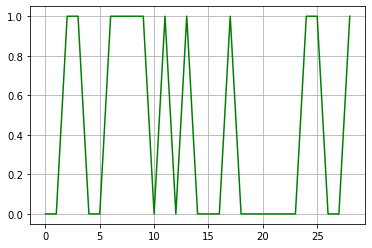

In [127]:
import matplotlib.pyplot as plt

graphdata = []
for i in range(0, len(alldata)):
    graphdata.append(alldata[i]['pdctPositive'])

plt.plot(graphdata, color)
plt.grid(True)
plt.show()

moving average golden cross ()

## Ziel: Klassifikation: Ist der nächste Tick (Tag) höher oder tiefer als heute
> Klassifikationstree

### Daten:
- Close heute
- Varianz heute (high - low)
- Moving Average (letztes Jahr)
- News Coverage (Google Trends) > pytrends

### Trainingsdatenset:
- von Paprikacoin API

In [131]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer
from sklearn import metrics

# CART
numberOfTestData = int(0.2 * len(alldata))

alldata = pd.DataFrame(alldata)

feature_cols = ['close', 'variance']

X = alldata[feature_cols]              # Features
y = alldata['pdctPositive']            # Target variable

X_train = X[:-numberOfTestData]
X_test  = X[-numberOfTestData:]
y_train = y[:-numberOfTestData]
y_test  = y[-numberOfTestData:]

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(max_depth=5)

# Train Decision Tree Classifer
clf = clf.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred).round(4))

Accuracy: 0.4


In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  
import numpy as np
from six import StringIO
from IPython.display import Image  
import pydotplus
import sklearn
import sklearn.neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

dot_data = StringIO()
export_graphviz(clf, 
                out_file=dot_data,
                feature_names = feature_cols)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png('classification_tree.png')
Image(graph.create_png())

InvocationException: GraphViz's executables not found

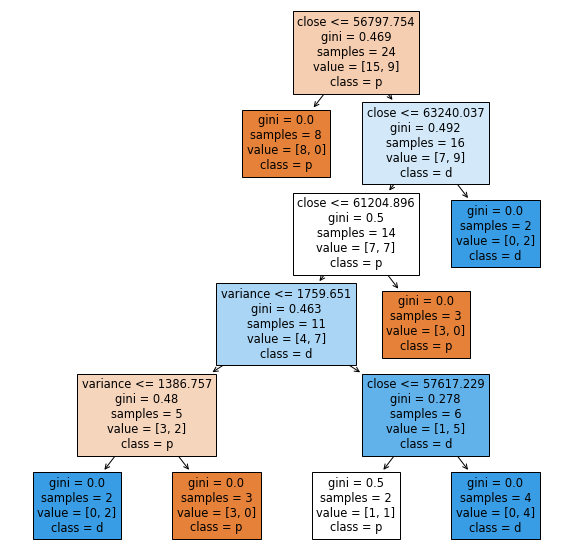

In [133]:

from sklearn import tree

fig = plt.figure(figsize=(10,10))
_ = tree.plot_tree(clf, 
                   feature_names=feature_cols,  
                   class_names='pdctPositive',
                   filled=True)